# FINDING TEEN MARKET SEGMENTS USING K-MEANS CLUSTERING

Rosa Karina Torres Calderon

In [64]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

Functions

In [4]:
def categoricalToNumerical(nameColumn, dataframe):
    enc = LabelEncoder()
    label_encoder = enc.fit(dataframe.iloc[:, nameColumn])
    print("Clases categoricas: ", label_encoder.classes_)
    t = label_encoder.transform(dataframe.iloc[:, nameColumn])
    dataframe.iloc[:, nameColumn] = t
    return dataframe

In [5]:
def checkIfNanValue(dataframe,nameCol):
    nanT = dataframe[nameCol].isnull().values.any()
    if nanT == True:
        nullValue = dataframe[nameCol].isnull().sum()
    else:
        nullValue = 0
    return nullValue   

# Step 1- Reading the data set

In [6]:
teens = pd.read_csv("snsdata.csv")
print(teens.head())
print(" ")
print('Tamaño del data set: ' + str(teens.shape))

   gradyear gender     age  friends  basketball  football  soccer  softball  \
0      2006      M  18.982        7           0         0       0         0   
1      2006      F  18.801        0           0         1       0         0   
2      2006      M  18.335       69           0         1       0         0   
3      2006      F  18.875        0           0         0       0         0   
4      2006    NaN  18.995       10           0         0       0         0   

   volleyball  swimming  ...  blonde  mall  shopping  clothes  hollister  \
0           0         0  ...       0     0         0        0          0   
1           0         0  ...       0     1         0        0          0   
2           0         0  ...       0     0         0        0          0   
3           0         0  ...       0     0         0        0          0   
4           0         0  ...       0     0         2        0          0   

   abercrombie  die  death  drunk  drugs  
0            0    0      

# Step 2- Exploring and preparing the data

In [7]:
print(teens.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 40 columns):
gradyear        30000 non-null int64
gender          27276 non-null object
age             24914 non-null float64
friends         30000 non-null int64
basketball      30000 non-null int64
football        30000 non-null int64
soccer          30000 non-null int64
softball        30000 non-null int64
volleyball      30000 non-null int64
swimming        30000 non-null int64
cheerleading    30000 non-null int64
baseball        30000 non-null int64
tennis          30000 non-null int64
sports          30000 non-null int64
cute            30000 non-null int64
sex             30000 non-null int64
sexy            30000 non-null int64
hot             30000 non-null int64
kissed          30000 non-null int64
dance           30000 non-null int64
band            30000 non-null int64
marching        30000 non-null int64
music           30000 non-null int64
rock            30000 non-null int64


In [8]:
print("Número de hombres  y mujeres: ")
print(teens["gender"].value_counts()) 
print("Número de personas que no especificaron su genero: ")
print(teens["gender"].isnull().sum())

Número de hombres  y mujeres: 
F    22054
M     5222
Name: gender, dtype: int64
Número de personas que no especificaron su genero: 
2724


In [9]:
print(teens['age'].describe())

count    24914.000000
mean        17.993950
std          7.858054
min          3.086000
25%         16.312000
50%         17.287000
75%         18.259000
max        106.927000
Name: age, dtype: float64


In [10]:
# Check if age has missing values 
print('Número de valores faltantes de la característica age: ' + str(checkIfNanValue(teens,'age')))

Número de valores faltantes de la característica age: 5086


In [14]:
# Replace suspicious age values 
teens.loc[teens.age < 13,'age'] = np.NaN 
teens.loc[teens.age > 20,'age'] = np.NaN 
            
print(teens['age'].describe())

count    24477.000000
mean        17.252429
std          1.157465
min         13.027000
25%         16.304000
50%         17.265000
75%         18.220000
max         19.995000
Name: age, dtype: float64


Data preparation - dummy coding missing values 

In [18]:
#Dummy coding
df_sex = pd.get_dummies(teens['gender'],dummy_na=True)
df_sex.columns = ['Femenino', 'Masculino','Sin genero']
print('Nombre de las columnas')
print(list(df_sex.columns))

print('')
print(df_sex['Femenino'].value_counts())
print(df_sex['Sin genero'].value_counts())

# Join the dummy variables to the main dataframe
teens_new = pd.concat([teens, df_sex], axis=1)
print('')
print(teens_new.head())
#df_new

Nombre de las columnas
['Femenino', 'Masculino', 'Sin genero']

1    22054
0     7946
Name: Femenino, dtype: int64
0    27276
1     2724
Name: Sin genero, dtype: int64

   gradyear gender     age  friends  basketball  football  soccer  softball  \
0      2006      M  18.982        7           0         0       0         0   
1      2006      F  18.801        0           0         1       0         0   
2      2006      M  18.335       69           0         1       0         0   
3      2006      F  18.875        0           0         0       0         0   
4      2006    NaN  18.995       10           0         0       0         0   

   volleyball  swimming  ...  clothes  hollister  abercrombie  die  death  \
0           0         0  ...        0          0            0    0      0   
1           0         0  ...        0          0            0    0      0   
2           0         0  ...        0          0            0    0      1   
3           0         0  ...        0          0

Data preparation - imputing missing values

In [21]:
# Calculate the average value of age using the year of graduation
print(teens_new["gradyear"].value_counts()) 
group = teens_new.groupby('gradyear')

groupmed = group['age'].mean()
print('')
print(groupmed.head(5))

2009    7500
2008    7500
2007    7500
2006    7500
Name: gradyear, dtype: int64

gradyear
2006    18.655858
2007    17.706172
2008    16.767701
2009    15.819573
Name: age, dtype: float64


In [23]:
# Fill nan values 
for i in range(0,teens_new.shape[0]):
    if pd.isnull(teens_new['age'][i]):
        if teens_new['gradyear'][i] == groupmed.index[0]:
            teens_new['age'][i] = groupmed.iloc[0]
        elif teens_new['gradyear'][i] == groupmed.index[1]: 
            teens_new['age'][i] = groupmed.iloc[1]
        elif teens_new['gradyear'][i] == groupmed.index[2]: 
            teens_new['age'][i] = groupmed.iloc[2]
        elif teens_new['gradyear'][i] == groupmed.index[3]: 
            teens_new['age'][i] = groupmed.iloc[3]
print(teens_new.head())      

/Users/karinatorres/anaconda3/envs/MachineLearning/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/karinatorres/anaconda3/envs/MachineLearning/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/karinatorres/anaconda3/envs/MachineLearning/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


   gradyear gender     age  friends  basketball  football  soccer  softball  \
0      2006      M  18.982        7           0         0       0         0   
1      2006      F  18.801        0           0         1       0         0   
2      2006      M  18.335       69           0         1       0         0   
3      2006      F  18.875        0           0         0       0         0   
4      2006    NaN  18.995       10           0         0       0         0   

   volleyball  swimming  ...  clothes  hollister  abercrombie  die  death  \
0           0         0  ...        0          0            0    0      0   
1           0         0  ...        0          0            0    0      0   
2           0         0  ...        0          0            0    0      1   
3           0         0  ...        0          0            0    0      0   
4           0         0  ...        0          0            0    0      0   

   drunk  drugs  Femenino  Masculino  Sin genero  
0      0   

In [24]:
# Verify if age has Nan values
print(checkIfNanValue(teens_new,'age'))

0


In [25]:
print(teens_new['age'].describe())

count    30000.000000
mean        17.237326
std          1.141821
min         13.027000
25%         16.282000
50%         17.238000
75%         18.212000
max         19.995000
Name: age, dtype: float64


In [26]:
teens_new = teens_new.drop(columns = ['gender', 'Masculino'])
print(teens_new.head())

#Normalize data and delete some columns
teens_new_proof = teens_new.drop(columns = ['age','Femenino','gradyear','friends'])
scaler = preprocessing.StandardScaler().fit(teens_new_proof)
scaler.transform(teens_new_proof) 

   gradyear     age  friends  basketball  football  soccer  softball  \
0      2006  18.982        7           0         0       0         0   
1      2006  18.801        0           0         1       0         0   
2      2006  18.335       69           0         1       0         0   
3      2006  18.875        0           0         0       0         0   
4      2006  18.995       10           0         0       0         0   

   volleyball  swimming  cheerleading  ...  shopping  clothes  hollister  \
0           0         0             0  ...         0        0          0   
1           0         0             0  ...         0        0          0   
2           0         0             0  ...         0        0          0   
3           0         0             0  ...         0        0          0   
4           0         0             0  ...         2        0          0   

   abercrombie  die  death  drunk  drugs  Femenino  Sin genero  
0            0    0      0      0      0     

/Users/karinatorres/anaconda3/envs/MachineLearning/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/karinatorres/anaconda3/envs/MachineLearning/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  import sys


array([[-0.33221726, -0.35769737, -0.2428741 , ..., -0.22040264,
        -0.1749076 , -0.31601901],
       [-0.33221726,  1.06004883, -0.2428741 , ..., -0.22040264,
        -0.1749076 , -0.31601901],
       [-0.33221726,  1.06004883, -0.2428741 , ..., -0.22040264,
        -0.1749076 , -0.31601901],
       ...,
       [-0.33221726,  1.06004883, -0.2428741 , ..., -0.22040264,
        -0.1749076 , -0.31601901],
       [-0.33221726, -0.35769737, -0.2428741 , ..., -0.22040264,
        -0.1749076 , -0.31601901],
       [ 2.15319868, -0.35769737, -0.2428741 , ..., -0.22040264,
        -0.1749076 , -0.31601901]])

# Step 3- Training a Model on the data

In [32]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(teens_new_proof)

In [33]:
print(kmeans.cluster_centers_)  

[[2.32076286e-01 2.19832830e-01 2.02762626e-01 1.46764510e-01
  1.29615822e-01 1.19648393e-01 9.23360672e-02 9.13550210e-02
  7.86406624e-02 1.16587529e-01 2.56210022e-01 9.46905780e-02
  1.17686301e-01 1.06306165e-01 4.66585567e-02 2.08570419e-01
  1.96209238e-01 2.93136601e-02 5.60373582e-01 1.75293333e-01
  2.60134207e-01 1.85143037e-01 7.92685320e-02 1.27536004e-02
  2.14692148e-01 8.50370835e-02 5.06612251e-02 2.09512224e-01
  3.10363772e-01 1.06698583e-01 5.88235294e-02 4.01051682e-02
  1.32362752e-01 9.16297139e-02 6.31008908e-02 3.13542362e-02
  9.52792057e-02]
 [0.00000000e+00 2.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 2.20000000e+01
  1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  1.00000000e+01 0.00000000e+00 1.00000000e+00 0.00000000e+00
  1.20000000e+01 2.00000000e+00 3.27000000e+02 0.000

# Step 4- Evaluating model performance

In [40]:
y_km = kmeans.fit_predict(teens_new_proof)
print(y_km)

[0 3 0 ... 0 0 0]


In [38]:
cluster = np.unique(y_km)
print('Número de clusters: ')
print(cluster)


Número de clusters: 
[0 1 2 3 4]


In [37]:
# Elements in each cluster
unique, counts = np.unique(y_km, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0 25481]
 [    1     1]
 [    2  1043]
 [    3  2253]
 [    4  1222]]


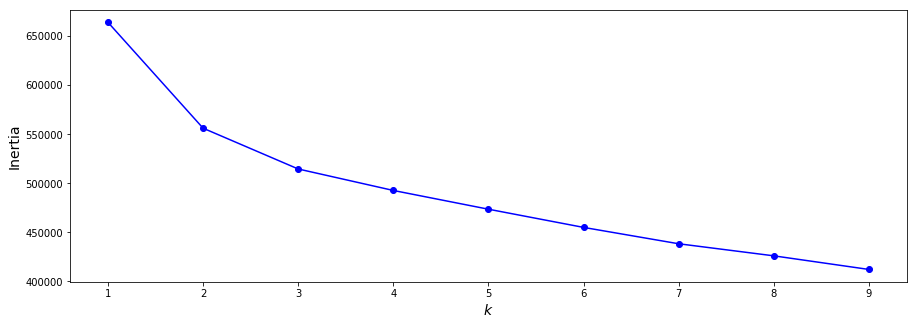

In [62]:
# Elbow method gives us an idea on what a good k number of clusters would be based on the sum of squared distance (SSE) between data points and their assigned clusters’ centroids
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(teens_new_proof) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(15, 5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

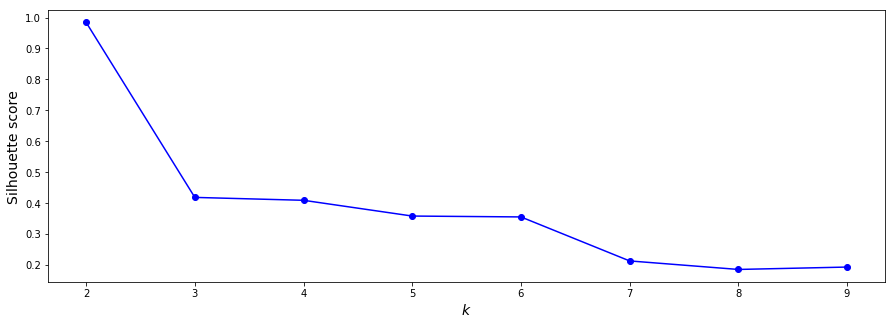

In [69]:
# Silhouette analysis can be used to determine the degree of separation between clusters. 
# If it is 0 –> the sample is very close to the neighboring clusters.
# If it is 1 –> the sample is far away from the neighboring clusters.
# If it is -1 –> the sample is assigned to the wrong clusters.  

silhouette_scores = [silhouette_score(teens_new_proof, model.labels_) for model in kmeans_per_k[1:]]
plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

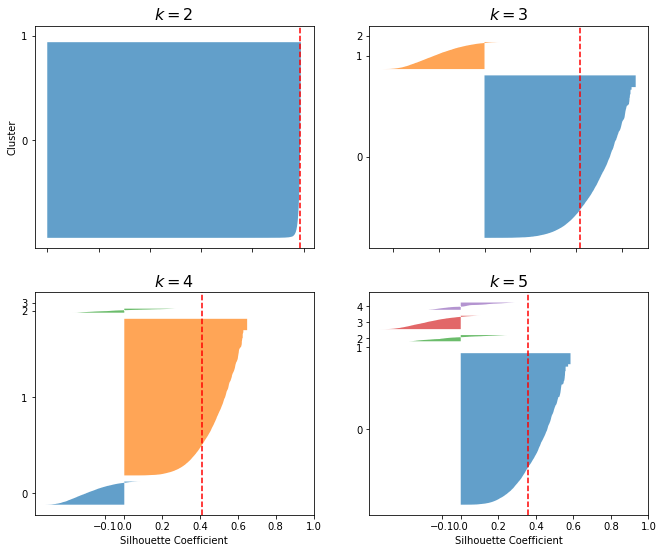

In [79]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(teens_new_proof, y_pred)

    padding = len(teens_new_proof) // 30
    pos = padding
    ticks = []

    # Get silhouette samples
    silhouette_vals = silhouette_samples(teens_new_proof, labels)

    # Silhouette plot
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
        
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (1, 2):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()
    

# Step 5- Improving model performance

In [49]:
# Add the column cluster ti de data set in order to see which cluster each user has been assigned
teens_new['cluster'] = y_km
print(teens_new.head(35))

    gradyear        age  friends  basketball  football  soccer  softball  \
0       2006  18.982000        7           0         0       0         0   
1       2006  18.801000        0           0         1       0         0   
2       2006  18.335000       69           0         1       0         0   
3       2006  18.875000        0           0         0       0         0   
4       2006  18.995000       10           0         0       0         0   
5       2006  18.655858      142           0         0       0         0   
6       2006  18.930000       72           0         0       0         0   
7       2006  18.322000       17           0         0       0         1   
8       2006  19.055000       52           0         0       0         0   
9       2006  18.708000       39           0         0       0         0   
10      2006  18.543000        8           0         0       0         0   
11      2006  19.463000       21           0         1       0         0   
12      2006

Look at the demographic characteristics of the clusters overall

In [48]:
group = teens_new.groupby('cluster')
#print(group.head(5))
groupmed = group['age'].mean()
print(groupmed.head(5))

0    25481
3     2253
4     1222
2     1043
1        1
Name: cluster, dtype: int64
cluster
0    17.256701
1    18.119000
2    17.382370
3    17.062312
4    17.031469
Name: age, dtype: float64


In [47]:
group = teens_new.groupby('cluster')
#print(group.head(5))
groupmed = group['Femenino'].mean()
print(groupmed.head(5))

0    25481
3     2253
4     1222
2     1043
1        1
Name: cluster, dtype: int64
cluster
0    0.719320
1    1.000000
2    0.761266
3    0.834443
4    0.859247
Name: Femenino, dtype: float64


In [46]:
group = teens_new.groupby('cluster')
#print(group.head(5))
groupmed = group['friends'].mean()
print(groupmed.head(5))

0    25481
3     2253
4     1222
2     1043
1        1
Name: cluster, dtype: int64
cluster
0    29.402496
1    44.000000
2    35.225312
3    32.899245
4    37.048282
Name: friends, dtype: float64
